# NBT property log analysis

> **The aim of this analysis is to identify and correct the various types of errors which reach our vm machines and aim to fix them. By analysing the logs and identifying where we are facing the errors we can:**
* improve our websites response rate 
* reduce bounce rate.
* Identify key sources of errors
* Identify key problems within our code base which would be applicable across properties
* Identify platform / property / VM  specific errors 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

<ipython-input-1-7d005de00701>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
# Reading the log file
df = pd.read_csv('combined_error_log.csv',index_col=False)

In [3]:
# Seeing data
df.head(5)

,IP,TIME,PLATFORM,USER_AGENT,REFERER,REQ_URL,REQ_FEED,DESC
0,172.29.63.154,16-2-2021 0:0:9,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/photomazza/health-relationship/10-weird-facts-about-sex/photoshow/26632460.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at w (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421252)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1426384)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1414517)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1414663at new Promise (<anonymous>)'
1,172.29.63.154,16-2-2021 0:0:22,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/articleshow/63263290.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at w (/opt/deployment/production/nbtweb_128/dist/server.js:1:1345021)at Object.<anonymous> (/opt/deployment/production/nbtweb_128/dist/server.js:1:1349761)at tryCatch (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtweb_128/dist/server.js:1:1338286)at /opt/deployment/production/nbtweb_128/dist/server.js:1:1338432at new Promise (<anonymous>)'
2,172.29.63.154,16-2-2021 0:0:26,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/fatwa-issued-for-bycott-of-chinese-products-in-up/videoshow/76496923.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at w (/opt/deployment/production/nbtweb_128/dist/server.js:1:1345021)at Object.<anonymous> (/opt/deployment/production/nbtweb_128/dist/server.js:1:1349761)at tryCatch (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtweb_128/dist/server.js:1:1338286)at /opt/deployment/production/nbtweb_128/dist/server.js:1:1338432at new Promise (<anonymous>)'
3,172.29.63.154,16-2-2021 0:0:36,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/articlelist/1567484.cms,NaN,'Error [ERR_HTTP_HEADERS_SENT]: Cannot set headers after they are sent to the clientat validateHeader (_http_outgoing.js:503:11)at ServerResponse.setHeader (_http_outgoing.js:510:3)at w (/opt/deployment/production/nbtweb_128/dist/server.js:1:1345021)at Object.<anonymous> (/opt/deployment/production/nbtweb_128/dist/server.js:1:1349761)at tryCatch (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtweb_128/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt

> **Dropping any duplicate types of errors based on the following combination**



In [4]:
df.drop_duplicates(subset=['PLATFORM','REQ_URL', 'REQ_FEED','DESC'], keep='last')
df.shape

(14330, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14330 entries, 0 to 14329
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IP          14330 non-null  object
 1   TIME        14330 non-null  object
 2   PLATFORM    14330 non-null  object
 3   USER_AGENT  14028 non-null  object
 4   REFERER     42 non-null     object
 5   REQ_URL     14330 non-null  object
 6   REQ_FEED    1677 non-null   object
 7   DESC        14330 non-null  object
dtypes: object(8)
memory usage: 895.8+ KB


* **Parsing time and date to get a more accurate analysis if needed**

In [6]:
# Adding parsed time 
# df['TIME'] = df['TIME'].apply(lambda x: x.strip())
# df['PARSED_TIME'] =df['TIME'].apply(lambda x: x[11:].strip())
# df['PARSED_TIME'] = df['PARSED_TIME'].apply(lambda x: x[:x.rindex(':')])
# df['PARSED_DATE'] = df['TIME'].apply(lambda x: x[:11].strip())
# df['PARSED_TIME'].head(30)
# df['PARSED_TIME'] = pd.to_datetime(df['PARSED_TIME'], format='%H:%M')
# df['PARSED_TIME'].head(30)
## Parsing time and date, converting to datetime
df['PARSED_DATE_TIME'] = pd.to_datetime(df['TIME'], format='%d-%m-%Y %H:%M:%S')
df['PARSED_DATE_TIME'].dt.time.head()


hour_labels = [str(x) + '-'+str(x+1) for x in range(23)]
hour_labels.append('23-0')
hour_labels

## Binning the same to make it a categorical variable.
df["BINNED_HOURS"] = pd.cut(df.PARSED_DATE_TIME.dt.hour, bins=24,labels=hour_labels)
df['BINNED_HOURS']

0        0-1 
1        0-1 
2        0-1 
3        0-1 
4        0-1 
        ...  
14325    23-0
14326    23-0
14327    23-0
14328    23-0
14329    23-0
Name: BINNED_HOURS, Length: 14330, dtype: category
Categories (24, object): [0-1 < 1-2 < 2-3 < 3-4 ... 20-21 < 21-22 < 22-23 < 23-0]

* **Categorizing urls based on page types**

In [7]:
def categorize_url(url):
    template_map = {
        '/amp_':'amp',
        'articleshow':'articleshow',
        'photoshow':'photoshow',
        'photolist':'photolist',
        'videoshow':'videoshow',
        'articlelist':'articlelist',
        'topics':'topics'
    }
    for template in template_map:
        if template in url:
            return template_map[template]
    return 'others'
df['URL_CATEGORY'] = df['REQ_URL'].apply(categorize_url)


**Categorizing Errors based on Error types**

How i found the categories:
1. Initially i was assuming we generally face two types of errors: **404** for invalid feed hit, or **9000ms** where feed responds slowly. However inspecting and grouping feed errors
2. First inspected the df, found **404 and undefined**, started with these as a base along with **null**
3. Characterized others as **"others"** manually inspected others one by one and found: **410 ,403, ['object Object'] timeout and ECONNRESET**


In [8]:
# How i found the categories:
# First inspected the df, found 404 and undefined, started with these as a base along with null
# Characterized others as "others" manually inspected others one by one and
# found: 410 ,403, ['object Object'] timeout
def categorize_error(error):
    #     categories = ['null','undefined','404','410','ERR_HTTP_HEADERS_SENT','9000ms']
    categories = {
       '[object Object]':'[object Object]','undefined':'undefined','404':'404','410':'410','403':'403','ECONNRESET':'ECONNRESET','ERR_HTTP_HEADERS_SENT':'ERR_HTTP_HEADERS_SENT','9000ms':'timeout'       
    }
    for cat in categories:
        if cat in error:
            return categories[cat]
    return 'other'
            
df['ERROR_TYPE'] = df['DESC'].apply(categorize_error)

*  **Further inspection reveals that some urls are broken with '-' '/-' or '%' values in SEO in between. It will be useful if we categorize these.**

In [9]:
# Categories to check where we failed in urls
# Manually inspecting, i found '-/' '/-/' and cases like
df['IS_URL_ERROR'] = df['REQ_URL'].apply(lambda x: '/-/' in x or '-/' in x or '%' in x)

In [10]:
## Some examples
df['REQ_URL'][df['IS_URL_ERROR']].head(5)

4     https://navbharattimes.indiatimes.com/video/entertainment/-/videoshow/45205441.cms                                                                     
14    https://navbharattimes.indiatimes.com/state/rajasthan/jaipur/heavy-rains-entire-rajasthan-since-morning-now-trouble/-/photoshow/77540719.cms?frmapp=yes
23    https://navbharattimes.indiatimes.com/-/videoshow/47393891.cms                                                                                         
24    https://navbharattimes.indiatimes.com/nbt-image-section/-2018-4-/photoshow/62483036.cms                                                                
27    https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-19-/amp_articleshow/62294318.cms                                                         
Name: REQ_URL, dtype: object

* **Analysing an error which was frequently occuring. It seems JS was appending this error without giving the actual description, need to analyse how its happening on the urls where it is occuring**

In [11]:
# Very vague type of error
df['DESC'][df['ERROR_TYPE'] == '[object Object]']

24       '[object Object]'
25       '[object Object]'
45       '[object Object]'
56       '[object Object]'
65       '[object Object]'
               ...        
14253    '[object Object]'
14260    '[object Object]'
14277    '[object Object]'
14281    '[object Object]'
14293    '[object Object]'
Name: DESC, Length: 848, dtype: object

In [12]:
# Further inspection reveals that some urls are broken with '-' in between. It will be useful if we categorize these.
df['REQ_URL'][df['ERROR_TYPE'] == '[object Object]']

24       https://navbharattimes.indiatimes.com/nbt-image-section/-2018-4-/photoshow/62483036.cms                                                                                                   
25       https://navbharattimes.indiatimes.com/sports/cricket/cricket-news/do-not-speculate-on-ms-dhoni-wait-till-ipl-2020-says-coach-ravi-shastri/articleshow/72242091.cms                        
45       https://navbharattimes.indiatimes.com/26-/amp_photoshow/2570809.cms                                                                                                                       
56       https://navbharattimes.indiatimes.com/movie-masti/television-news/bigg-boss-10-sunny-leone-super-excited-for-the-reality-show/articleshow/55553661.cms                                    
65       https://navbharattimes.indiatimes.com/world/pakistan/russian-forces-arrive-in-pakistan-for-joint-military-drill/articleshow/54480368.cms?utm_campaign=web&utm_medium=Twitter&utm_source=tw
                    

* **Following are the amp urls where the url is correctly formed, but still it fails** 

In [13]:
df['REQ_URL'][(df['URL_CATEGORY'] == 'amp') & ~(df['IS_URL_ERROR'])].head(20)

17      https://navbharattimes.indiatimes.com/-20-ap/amp_articleshow/47653141.cms                                                                                                     
32      https://navbharattimes.indiatimes.com/video/news/howdy-modi-pm-modi-holds-round-table-meeting-with-ceos-from-energy-sector/amp_videoshow/71240499.cms                         
33      https://navbharattimes.indiatimes.com/video/news/howdy-modi-pm-modi-holds-round-table-meeting-with-ceos-from-energy-sector/amp_videoshow/71240499.cms                         
66      https://navbharattimes.indiatimes.com/tv/news/bigg-boss-13-contestant-shehnaaz-gill-hits-7-million-followers-on-instagram/amp_articleshow/80924633.cms                        
119     https://navbharattimes.indiatimes.com/sports/cricket/india-and-west-indies/locals-hope-to-see-sanju-samson-in-action-in-second-t20i/amp_articleshow/72419074.cms              
120     https://navbharattimes.indiatimes.com/sports/cricket/india-and-west-indies/lo

### Helper functions for plotting

* Pie chart

In [14]:
def plot_pie_chart(df=df,column="",labels=[],title="",percentage_dist=None):
    if not column:
        return
    plt.figure(figsize=(10,8))
    if percentage_dist:
        column_val_percentage = percentage_dist
    else:
        column_val_percentage =  df[column].value_counts(normalize=True) * 100
    if not labels:
        labels = df[column].value_counts().index
    explode=(0,0.1)
    plt.pie(column_val_percentage,explode=explode,labels=labels, autopct='%.1f%%', 
           shadow=False, startangle=0,   
           pctdistance=1.2,labeldistance=1.4)
    plt.title(title)
    plt.show()

* Percentage vs count - barchart

In [15]:
### Helper function to plot charts
def plot_percentage_and_count(column='',supertitle='',title_count='',title_percentage='',xlabel='',ylabel_count='COUNT',ylabel_percentage='PERCENTAGE',df=df):
    if not column:
        return
    fig,ax= plt.subplots(1,2,figsize=(16,8))
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)

    bp = sns.barplot(data=df,x=column,y=column,orient='v',estimator=lambda x: len(x) / len(df) * 100,ax=ax[0])
    for rect in bp.patches:
        bp.text (rect.get_x() + rect.get_width() // 2,rect.get_height(),"%.2f%%"% rect.get_height(), weight='bold' )
    ax[0].set_title(title_percentage)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel_percentage)

    ## Error types counts
    sns.countplot(df[column],ax=ax[1])
    ax[1].set_title(title_count)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel(ylabel_count)

    fig.suptitle(supertitle)

    plt.show()

* Heat map for pivots / grouped data

In [16]:
def plot_heat_map(data=None,title="",xlabel="",ylabel="",cmap='Oranges'):
    if data is None:
        return
    plt.figure(figsize=(16,8))
    sns.heatmap(data,linewidths=.5,annot=True,cmap=cmap,fmt="d")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    

## Visualizing the errors

### Understanding platform level distribution for errors

In [17]:
df['PLATFORM'].value_counts(normalize=True) * 100

desktop    80.809491
mobile     19.190509
Name: PLATFORM, dtype: float64

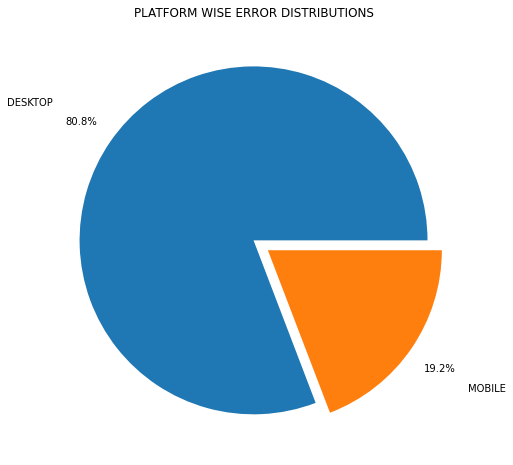

In [18]:
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
plot_pie_chart(column='PLATFORM',labels=['DESKTOP','MOBILE'],title='PLATFORM WISE ERROR DISTRIBUTIONS')

### Identifying where **the url has the problem**

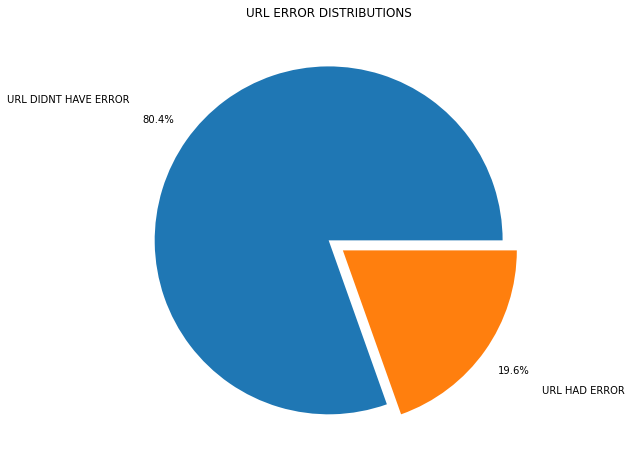

In [19]:
plot_pie_chart(column='IS_URL_ERROR',labels=['URL DIDNT HAVE ERROR','URL HAD ERROR'],title='URL ERROR DISTRIBUTIONS')


> Some examples where url was the problem

In [20]:
df['REQ_URL'][df['IS_URL_ERROR']].head(5)

4     https://navbharattimes.indiatimes.com/video/entertainment/-/videoshow/45205441.cms                                                                     
14    https://navbharattimes.indiatimes.com/state/rajasthan/jaipur/heavy-rains-entire-rajasthan-since-morning-now-trouble/-/photoshow/77540719.cms?frmapp=yes
23    https://navbharattimes.indiatimes.com/-/videoshow/47393891.cms                                                                                         
24    https://navbharattimes.indiatimes.com/nbt-image-section/-2018-4-/photoshow/62483036.cms                                                                
27    https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-19-/amp_articleshow/62294318.cms                                                         
Name: REQ_URL, dtype: object

### Further categorizing the url  based  errors on  category of these urls and error types

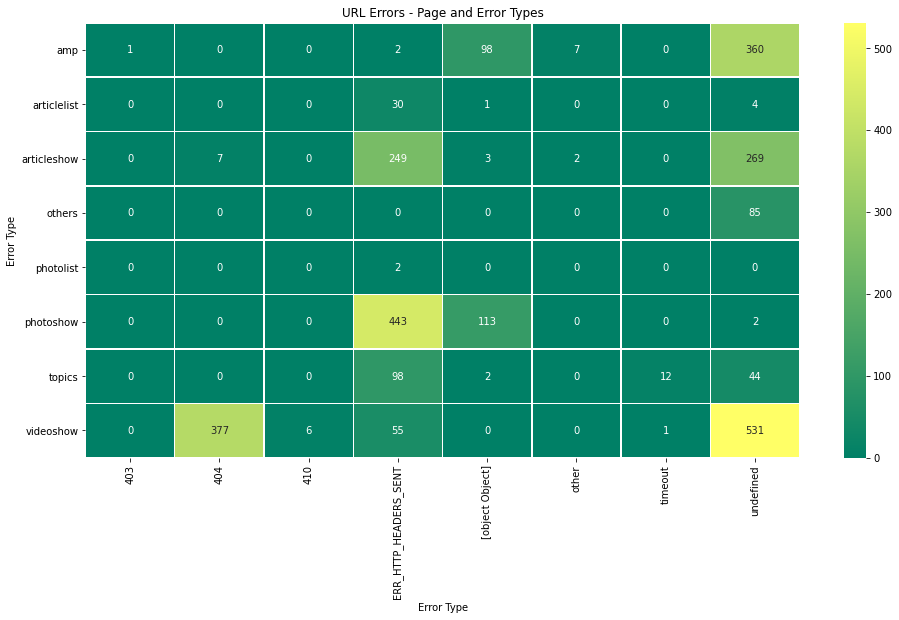

In [21]:
url_errors_grouped =  df[df['IS_URL_ERROR']].groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=url_errors_grouped,title='URL Errors - Page and Error Types',xlabel='Error Type',ylabel='Error Type',cmap='summer')


> Above heatmap contains all urls with errors, and error types on those urls

### Understanding about feed errors wherever they occur

In [22]:
## Seeing feed errors vs others
df[~(df['REQ_FEED'].isnull())].count()[0] / df.shape[0] 
# 41.8 percent feederrors 

0.11702721563154223

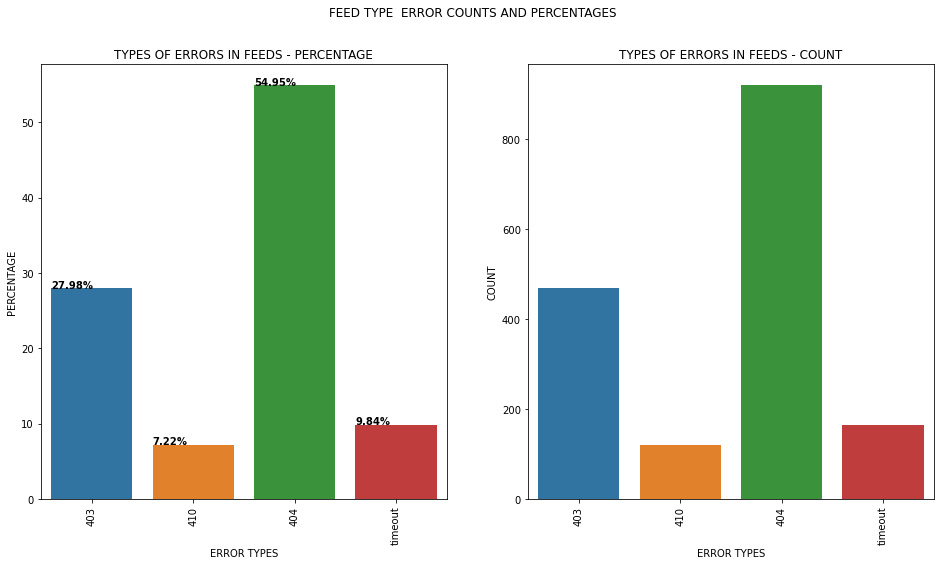

In [23]:
error_types_percentage_feeds = df[(df['ERROR_TYPE'] == '404') | (df['ERROR_TYPE'] == '410') | (df['ERROR_TYPE'] == '403') |  (df['ERROR_TYPE'] == 'timeout')] 

plot_percentage_and_count(df=error_types_percentage_feeds,column='ERROR_TYPE',xlabel="ERROR TYPES",title_count='TYPES OF ERRORS IN FEEDS - COUNT',title_percentage='TYPES OF ERRORS IN FEEDS - PERCENTAGE',supertitle='FEED TYPE  ERROR COUNTS AND PERCENTAGES')
# plot_pie_chart(percentage_dist=error_types_percentage_dist,labels=labels,title="FEED ERROR DISTRIBUTIONS")


> It seems that **majority of the feed errors are 404s**. However some feed errors are **410 and 403** respectively, which are surprising.

### Understanding distribution of errors on various templates

In [24]:
df['URL_CATEGORY'].value_counts()

articleshow    6119
photoshow      2050
videoshow      1996
articlelist    1335
others         1236
amp            1003
topics         414 
photolist      177 
Name: URL_CATEGORY, dtype: int64

> **Articlelist + timeout issues bifurcation**

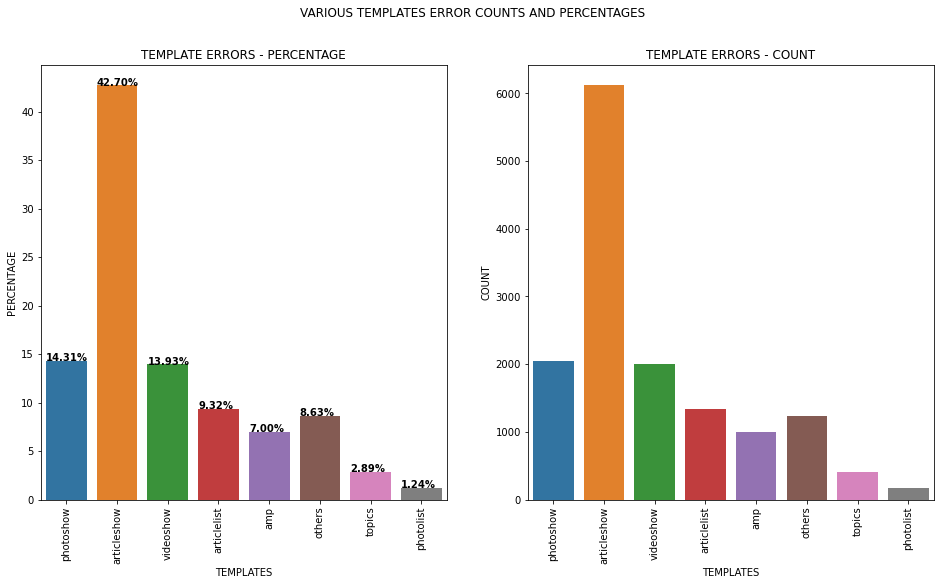

In [25]:
plot_percentage_and_count(column='URL_CATEGORY',xlabel="TEMPLATES",title_count='TEMPLATE ERRORS - COUNT',title_percentage='TEMPLATE ERRORS - PERCENTAGE',supertitle='VARIOUS TEMPLATES ERROR COUNTS AND PERCENTAGES')

> It seems that articlelist has the highest number of errors, followed by articleshow,amp and videoshow

### Understanding distribution of various error types

In [26]:
df['ERROR_TYPE'].value_counts()

ERR_HTTP_HEADERS_SENT    8395
undefined                3341
404                      921 
[object Object]          848 
403                      469 
timeout                  165 
410                      121 
other                    69  
ECONNRESET               1   
Name: ERROR_TYPE, dtype: int64

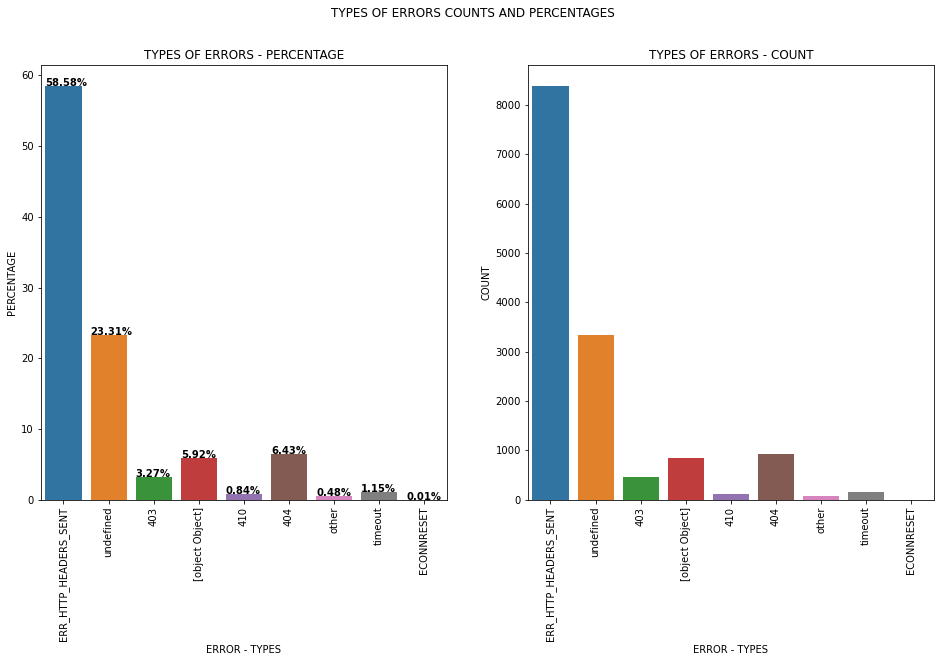

In [27]:
plot_percentage_and_count(column='ERROR_TYPE',xlabel="ERROR - TYPES",title_count='TYPES OF ERRORS - COUNT',title_percentage='TYPES OF ERRORS - PERCENTAGE',supertitle='TYPES OF ERRORS COUNTS AND PERCENTAGES')

### Error type vs pagetype heatmap

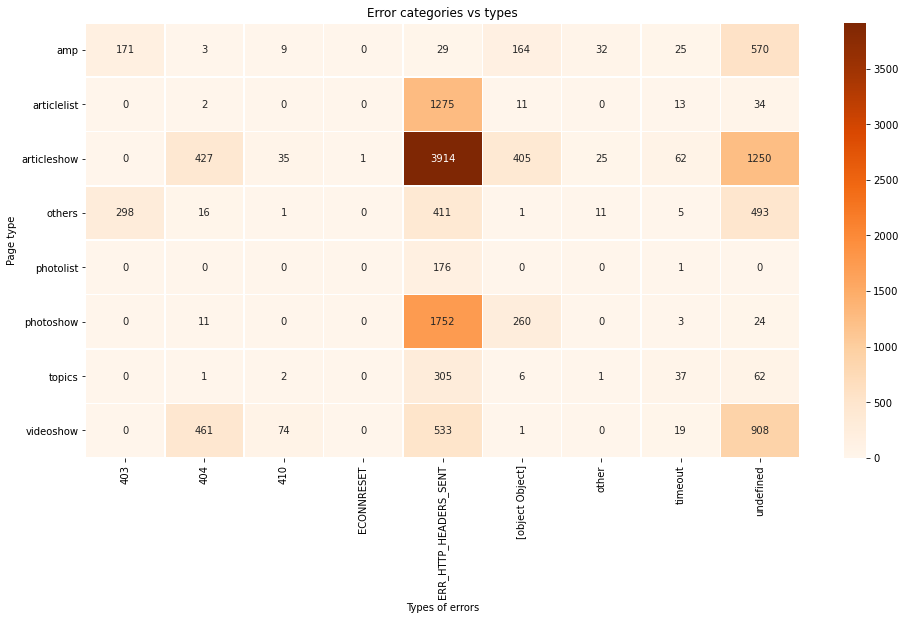

In [28]:
# Creating what type of templates have what type of errors
categories_vs_error_grouped =  df.groupby(['URL_CATEGORY','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=categories_vs_error_grouped,title='Error categories vs types',xlabel='Types of errors',ylabel='Page type',cmap='Oranges')

### Checking if time plays a factor in errors - Templates and Error Types


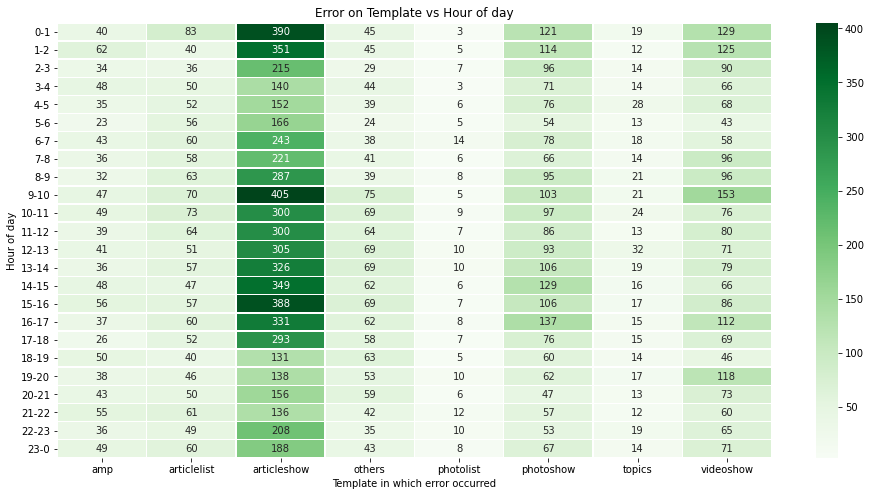

In [29]:
# Creating what type of templates have what type of errors

time_vs_url_category =  df.groupby(['BINNED_HOURS','URL_CATEGORY']).size().unstack(fill_value=0)

plot_heat_map(data=time_vs_url_category,title='Error on Template vs Hour of day',xlabel='Template in which error occurred',ylabel='Hour of day',cmap='Greens')

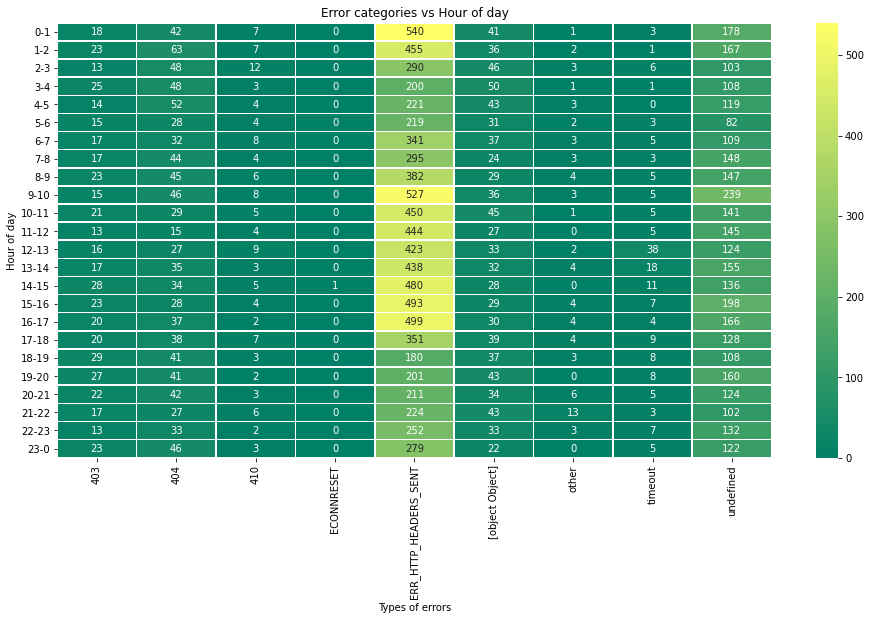

In [30]:
# Creating what type of templates have what type of errors
categories_vs_error_hour_of_day =  df.groupby(['BINNED_HOURS','ERROR_TYPE']).size().unstack(fill_value=0)
plot_heat_map(data=categories_vs_error_hour_of_day,title='Error categories vs Hour of day',xlabel='Types of errors',ylabel='Hour of day',cmap='summer')



> Improvements

* BOT url - classification
* ARticlelist 404s - Feed urls / Timeout ratio
* Amp pages ampnext / vs cases
* '%' url check if correctly parsed

### Seeing where timeouts are happening

In [31]:
timed_out_df = df[df['ERROR_TYPE'] =='timeout']
timed_out_df.head(5)

,IP,TIME,PLATFORM,USER_AGENT,REFERER,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
73,172.29.63.154,16-2-2021 0:7:25,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/india/court-asks-maharashtra-sdma-to-take-decision-on-dussehra-procession-of-nanded-gurdwara/articleshow/78748075.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=78748075,'Error: timeout of 9000ms exceeded',2021-02-16 00:07:25,0-1,articleshow,timeout,False
676,172.29.63.154,16-2-2021 0:45:24,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/mobile-phones/xiaomi-redmi-a2/amp_gadgetshow.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/pwagn_productshow.cms?pagetype=gadgetshow&productid=xiaomi-redmi-a2&category=mobile&uri=/tech/mobile/xiaomi-redmi-a2&feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 00:45:24,0-1,amp,timeout,False
685,172.29.63.154,16-2-2021 0:46:3,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/video/news/sexual-favours-common-in-entertainment-world-politics-shatrughan-sinha/videoshow/feedback.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/feedback.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 00:46:03,0-1,videoshow,timeout,False
1030,172.29.63.154,16-2-2021 1:15:8,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/metro/lucknow/other-news/congressmen-protesting-in-front-of-raj-bhavan-arrested/videoshow/77206740.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/77206740.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 01:15:08,1-2,videoshow,timeout,False
1881,172.29.63.154,16-2-2021 2:30:10,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/state/uttar-pradesh/articlelist/21236867.cms?curpg=3,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articlelist/21236867.cms?feedtype=sjson&curpg=3,'Error: timeout of 9000ms exceeded',2021-02-16 02:30:10,2-3,articlelist,timeout,False


**Percentage of errors w.r.t total number of errors**

In [32]:
timed_out_df.shape[0] / df.shape[0] * 100

1.1514305652477321

In [33]:
timed_out_df.PLATFORM.value_counts()

desktop    115
mobile     50 
Name: PLATFORM, dtype: int64

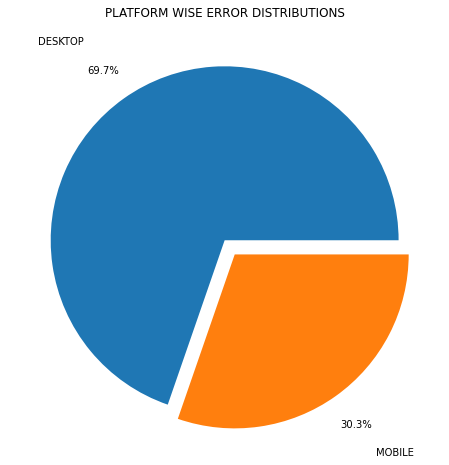

In [34]:
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
# Seeing platform specific
# 71 percent of errors are in desktop in this ip while 28 in mobile
percentage_dist = timed_out_df.PLATFORM.value_counts(normalize=True) * 100
plot_pie_chart(df=timed_out_df,column='PLATFORM',labels=['DESKTOP','MOBILE'],title='PLATFORM WISE ERROR DISTRIBUTIONS')

**Heatmap platform wise timeouts**

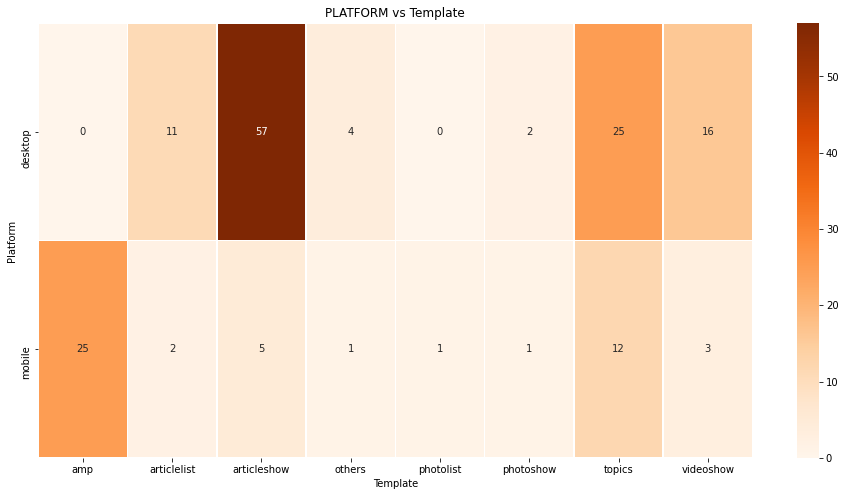

In [35]:
# Creating what type of templates have what type of errors
platforms_vs_templates_timeouts =  timed_out_df.groupby(['PLATFORM','URL_CATEGORY']).size().unstack(fill_value=0)
plot_heat_map(data=platforms_vs_templates_timeouts,title='PLATFORM vs Template',xlabel='Template',ylabel='Platform',cmap='Oranges')



### Checking timeouts for articleshow pages ( including amp)


In [54]:
timed_out_df[(timed_out_df['URL_CATEGORY'] == 'articleshow') | (timed_out_df['URL_CATEGORY'] == 'amp')]

,IP,TIME,PLATFORM,USER_AGENT,REFERER,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
73,172.29.63.154,16-2-2021 0:7:25,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/india/court-asks-maharashtra-sdma-to-take-decision-on-dussehra-procession-of-nanded-gurdwara/articleshow/78748075.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=78748075,'Error: timeout of 9000ms exceeded',2021-02-16 00:07:25,0-1,articleshow,timeout,False
676,172.29.63.154,16-2-2021 0:45:24,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/mobile-phones/xiaomi-redmi-a2/amp_gadgetshow.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/pwagn_productshow.cms?pagetype=gadgetshow&productid=xiaomi-redmi-a2&category=mobile&uri=/tech/mobile/xiaomi-redmi-a2&feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 00:45:24,0-1,amp,timeout,False
1964,172.29.63.154,16-2-2021 2:38:59,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/sports/cricket/cricket-news/cheteshwar-pujara-birthday-special-watch-his-5-most-popular-test-innings/articleshow/80437540.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=51058664,'Error: timeout of 9000ms exceeded',2021-02-16 02:38:59,2-3,articleshow,timeout,False
1969,172.29.63.154,16-2-2021 2:39:33,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/gadgets-news/lg-launched-new-range-of-premium-category-tv-kno-details/articleshow/feedback.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/feedback.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 02:39:33,2-3,articleshow,timeout,False
1986,172.29.63.154,16-2-2021 2:42:2,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/state/uttar-pradesh/gorakhpur/prevention-is-being-done-in-beauty-parlor-with-ppe-kit-and-social-distancing/articleshow/76509507.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/feedback.cms?feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 02:42:02,2-3,articleshow,timeout,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,172.29.63.154,16-2-2021 22:27:3,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tv/bigg-boss/bigg-boss-14-weekend-ka-vaar-9-jan-2021-day-97-written-update/articleshow/80190258.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_topicfeeds.cms?feedtype=sjson&q=%E0%A4%B6%E0%A4%BE%E0%A4%B0%E0%A5%80%E0%A4%B0%E0%A4%BF%E0%A4%95-%E0%A4%B6%E0%A5%8B%E0%A4%B7%E0%A4%A3&type=default&pagetype=topicsall&amptype=&platform=desktop&version=v9,'Error: timeout of 9000ms exceeded',2021-02-16 22:27:03,22-23,articleshow,timeout,False
13764,172.29.63.154,16-2-2021 22:51:23,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/india/quotespecially-for-army-air-branch-no-39/articleshow/17682737.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=17682737,'Error: timeout of 9000ms exceeded',2021-02-16 22:51:23,22-23,articleshow,timeout,False
13768,172.29.63.154,16-2-2021 22:52:33,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/india/india-and-pakistan-fight-to-get-their-basmati-rice-recognised-by-the-european-union/articleshow/78994015.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=78994015,'Error: timeout of 9000ms exceeded',2021-02-16 22:52:33,22-23,articleshow,timeout,False
13945,172.29.63.154,16-2-2021 23:11:48,desktop,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/india/cpi-m-should-also-stop-chief-minister-npr-opposing-nrc/articleshow/72955939.cms,https

### Checking where amp pages are failing and how

In [36]:
amp_errors_df = df[df['URL_CATEGORY'] == 'amp']

In [37]:

amp_errors_df.PLATFORM.value_counts()

mobile    1003
Name: PLATFORM, dtype: int64

In [38]:
amp_errors_df.head()

,IP,TIME,PLATFORM,USER_AGENT,REFERER,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
17,172.29.63.154,16-2-2021 0:1:33,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/-20-ap/amp_articleshow/47653141.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/nbtmweb_162/dist/server.js:1:184813)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:509042at T (/opt/deployment/production/nbtmweb_162/dist/server.js:1:509246)at e.HBEh.t.render (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518517)at e.HBEh.t.read (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518096)at renderToString (/opt/deployment/production/nbtmweb_162/dist/server.js:1:523287)at _ (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421475)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1425944)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)',2021-02-16 00:01:33,0-1,amp,undefined,False
27,172.29.63.154,16-2-2021 0:2:27,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-19-/amp_articleshow/62294318.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/nbtmweb_162/dist/server.js:1:184813)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:509042at T (/opt/deployment/production/nbtmweb_162/dist/server.js:1:509246)at e.HBEh.t.render (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518517)at e.HBEh.t.read (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518096)at renderToString (/opt/deployment/production/nbtmweb_162/dist/server.js:1:523287)at _ (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421475)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1425944)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)',2021-02-16 00:02:27,0-1,amp,undefined,True
32,172.29.63.154,16-2-2021 0:2:54,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/video/news/howdy-modi-pm-modi-holds-round-table-meeting-with-ceos-from-energy-sector/amp_videoshow/71240499.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_videoshow/71240499.cms?feedtype=sjson,'Error: Request failed with status code 410',2021-02-16 00:02:54,0-1,amp,410,False
33,172.29.63.154,16-2-2021 0:2:55,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/video/news/howdy-modi-pm-modi-holds-round-table-meeting-with-ceos-from-energy-sector/amp_videoshow/71240499.cms,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_162/dist/server.js:1:706931)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1426033)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1414517)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1414663at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1414461at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1426812',2021-02-16 00:02:55,0-1,amp,undefined,False
45,172.29.63.154,16-2-2021 0:3:42,mobile,Apache-HttpClient/4.5.5 (Java

In [39]:
amp_errors_df.ERROR_TYPE.value_counts()

undefined                570
403                      171
[object Object]          164
other                    32 
ERR_HTTP_HEADERS_SENT    29 
timeout                  25 
410                      9  
404                      3  
Name: ERROR_TYPE, dtype: int64

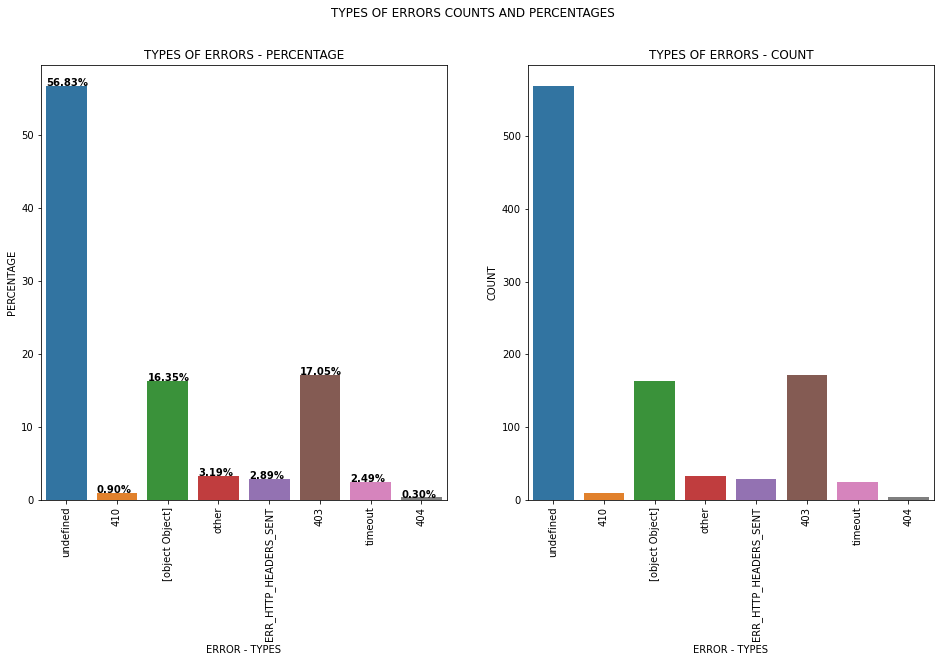

In [40]:
plot_percentage_and_count(df=amp_errors_df,column='ERROR_TYPE',xlabel="ERROR - TYPES",title_count='TYPES OF ERRORS - COUNT',title_percentage='TYPES OF ERRORS - PERCENTAGE',supertitle='TYPES OF ERRORS COUNTS AND PERCENTAGES')

In [41]:
amp_errors_df[amp_errors_df['ERROR_TYPE'] =='undefined']

,IP,TIME,PLATFORM,USER_AGENT,REFERER,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
17,172.29.63.154,16-2-2021 0:1:33,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/-20-ap/amp_articleshow/47653141.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/nbtmweb_162/dist/server.js:1:184813)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:509042at T (/opt/deployment/production/nbtmweb_162/dist/server.js:1:509246)at e.HBEh.t.render (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518517)at e.HBEh.t.read (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518096)at renderToString (/opt/deployment/production/nbtmweb_162/dist/server.js:1:523287)at _ (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421475)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1425944)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)',2021-02-16 00:01:33,0-1,amp,undefined,False
27,172.29.63.154,16-2-2021 0:2:27,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/breaking-news-in-hindi/-19-/amp_articleshow/62294318.cms,NaN,'TypeError: Cannot read property 'pagetype' of undefinedat t.value (/opt/deployment/production/nbtmweb_162/dist/server.js:1:184813)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:509042at T (/opt/deployment/production/nbtmweb_162/dist/server.js:1:509246)at e.HBEh.t.render (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518517)at e.HBEh.t.read (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518096)at renderToString (/opt/deployment/production/nbtmweb_162/dist/server.js:1:523287)at _ (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421475)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1425944)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)',2021-02-16 00:02:27,0-1,amp,undefined,True
33,172.29.63.154,16-2-2021 0:2:55,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/video/news/howdy-modi-pm-modi-holds-round-table-meeting-with-ceos-from-energy-sector/amp_videoshow/71240499.cms,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_162/dist/server.js:1:706931)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1426033)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)at Generator.prototype.(anonymous function) [as next] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:117:21)at n (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1414517)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1414663at new Promise (<anonymous>)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1414461at /opt/deployment/production/nbtmweb_162/dist/server.js:1:1426812',2021-02-16 00:02:55,0-1,amp,undefined,False
46,172.29.63.154,16-2-2021 0:3:43,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/26-/amp_photoshow/2570809.cms,NaN,'TypeError: Cannot read property 'ampnext' of undefinedat r (/opt/deployment/production/nbtmweb_162/dist/server.js:1:706931)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1426033)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generato

In [42]:
def categorize_url_amp(url):
    template_map = {
        '_articleshow':'articleshow',
        '_photoshow':'photoshow',
        '_photolist':'photolist',
        '_videoshow':'videoshow',
        '_articlelist':'articlelist',
        '_liveblog':'liveblog',
        '_topics':'topics'
    }
    for template in template_map:
        if template in url:
            return template_map[template]
    return 'others'
amp_errors_df['URL_CATEGORY'] = amp_errors_df['REQ_URL'].apply(categorize_url_amp)


<ipython-input-42-0bf2b22fc074>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amp_errors_df['URL_CATEGORY'] = amp_errors_df['REQ_URL'].apply(categorize_url_amp)


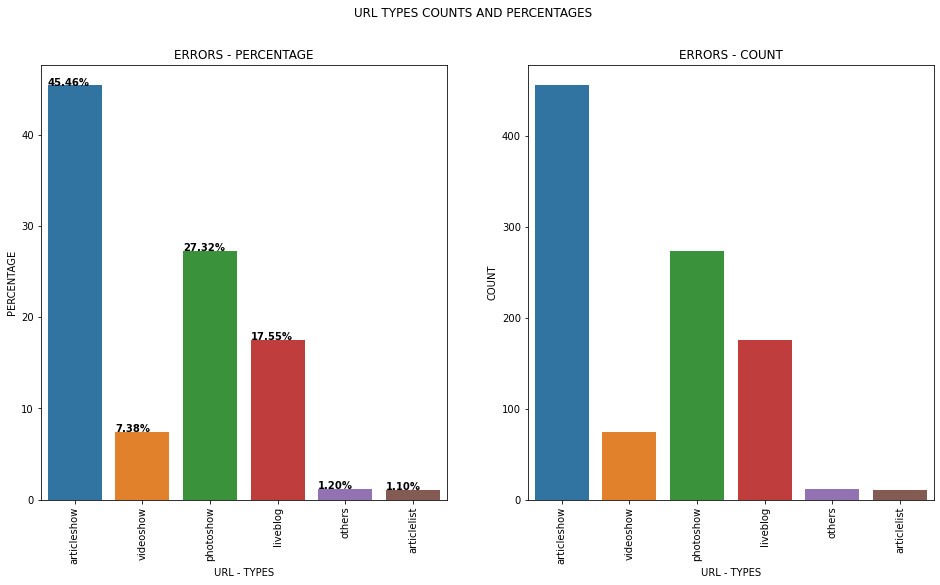

In [43]:
plot_percentage_and_count(df=amp_errors_df,column='URL_CATEGORY',xlabel="URL - TYPES",title_count='ERRORS - COUNT',title_percentage='ERRORS - PERCENTAGE',supertitle='URL TYPES COUNTS AND PERCENTAGES')

* **Understanding 'others'**

In [44]:
# Only 7 records in others categories
amp_errors_df[amp_errors_df['URL_CATEGORY'] =='others'].head(7)

,IP,TIME,PLATFORM,USER_AGENT,REFERER,REQ_URL,REQ_FEED,DESC,PARSED_DATE_TIME,BINNED_HOURS,URL_CATEGORY,ERROR_TYPE,IS_URL_ERROR
676,172.29.63.154,16-2-2021 0:45:24,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/mobile-phones/xiaomi-redmi-a2/amp_gadgetshow.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/pwagn_productshow.cms?pagetype=gadgetshow&productid=xiaomi-redmi-a2&category=mobile&uri=/tech/mobile/xiaomi-redmi-a2&feedtype=sjson,'Error: timeout of 9000ms exceeded',2021-02-16 00:45:24,0-1,others,timeout,False
2235,172.29.63.154,16-2-2021 3:18:52,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/mobile-phones/ui-phones/amp_gadgetshow.cms,NaN,'TypeError: Cannot read property 'lcuname' of nullat t.value (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1818314)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:509042at T (/opt/deployment/production/nbtmweb_162/dist/server.js:1:509246)at e.HBEh.t.render (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518517)at e.HBEh.t.read (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518096)at renderToString (/opt/deployment/production/nbtmweb_162/dist/server.js:1:523287)at _ (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421475)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1425944)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)',2021-02-16 03:18:52,3-4,others,other,False
4368,172.29.63.154,16-2-2021 7:53:24,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/compare-mobile-phones/sony-xperia-e3-vs-wileyfox-spark/amp_compareshow.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_topicfeeds.cms?feedtype=sjson&q=%E0%A4%B8%E0%A4%A4%E0%A5%80%E0%A4%B6-%E0%A4%B8%E0%A4%BF%E0%A4%95%E0%A4%B0%E0%A4%B5%E0%A4%BE%E0%A4%B0&type=default&pagetype=topicsall&amptype=ampdefault&version=v9,'Error: timeout of 9000ms exceeded',2021-02-16 07:53:24,7-8,others,timeout,False
4369,172.29.63.154,16-2-2021 7:53:24,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/compare-mobile-phones/sony-xperia-e3-vs-wileyfox-spark/amp_compareshow.cms,NaN,'TypeError: Cannot read property 'replace' of undefinedat t.value (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1091402)at /opt/deployment/production/nbtmweb_162/dist/server.js:1:509042at T (/opt/deployment/production/nbtmweb_162/dist/server.js:1:509246)at e.HBEh.t.render (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518517)at e.HBEh.t.read (/opt/deployment/production/nbtmweb_162/dist/server.js:1:518096)at renderToString (/opt/deployment/production/nbtmweb_162/dist/server.js:1:523287)at _ (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1421475)at Object.<anonymous> (/opt/deployment/production/nbtmweb_162/dist/server.js:1:1425944)at tryCatch (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:65:40)at Generator.invoke [as _invoke] (/opt/deployment/production/nbtmweb_162/node_modules/regenerator-runtime/runtime.js:303:22)',2021-02-16 07:53:24,7-8,others,undefined,False
7958,172.29.63.154,16-2-2021 12:55:24,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/laptops/lenovo-flex-2-14d-notebook/amp_gadgetshow.cms,https://navbharattimesfeeds.indiatimes.com/pwafeeds/sc_articleshow.cms?feedtype=sjson&version=v9&msid=64251009,'Error: timeout of 9000ms exceeded',2021-02-16 12:55:24,12-13,others,timeout,False
8166,172.29.63.154,16-2-2021 13:13:51,mobile,Apache-HttpClient/4.5.5 (Java/1.8.0_241),NaN,https://navbharattimes.indiatimes.com/tech/compare-mobile-phones/Samsung-C3212-vs-Spice-Mi-315-vs-Yu-Yunique-2/amp_compareshow.cms,NaN,'Error [ERR_HTTP_H

## Understanding referer / user agents available

> It seems that user agent that is being forwarded is of apache server only, the other smaller values that are recieved must be direct production server hits made by team in between

In [48]:
df.USER_AGENT.value_counts()
df.USER_AGENT.value_counts(normalize =True)

Apache-HttpClient/4.5.5 (Java/1.8.0_241)                                                                                                        0.987810
check_http/v1.4.15 (nagios-plugins 1.4.15)                                                                                                      0.008554
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML like Gecko) Chrome/88.0.4324.150 Safari/537.36                        0.001283
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML like Gecko) Chrome/84.0.4143.7 Safari/537.36 Chrome-Lighthouse        0.000713
Mozilla/5.0 (Linux; Android 7.0; Moto G (4)) AppleWebKit/537.36 (KHTML like Gecko) Chrome/84.0.4143.7 Mobile Safari/537.36 Chrome-Lighthouse    0.000642
Test Certificate Info                                                                                                                           0.000428
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML like Gecko) Ch